In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install imbalanced-learn


In [28]:
import pandas as pd
import torch
import clip
from PIL import Image, UnidentifiedImageError 
import os
from tqdm import tqdm  
import efficientnet_pytorch as Efficinet

# Set paths
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/data_NOH_V2.csv'
base_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'

# Load the CSV
df = pd.read_csv(data_path)

# Load the CLIP model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to process a single image and text entry through CLIP
def process_image_and_text(image_path, text, model, preprocess):
    # Open image with error handling for corrupt files
    try:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    except (UnidentifiedImageError, OSError) as e:
        print(f"Error opening image {image_path}: {e}. Skipping.")
        return None, None  # Return None to indicate failure

    # Process text
    text_tokens = clip.tokenize([text]).to(device)

    # Get embeddings
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_tokens)

    return image_features.cpu().numpy(), text_features.cpu().numpy()

# Initialize the list to keep track of successfully processed image paths
processed_image_paths = []

# Iterate over the dataframe and compute embeddings with progress bar
image_embeddings = []
text_embeddings = []

# Wrap the iteration in tqdm for progress tracking
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows", unit="row"):
    img_path = os.path.join(base_image_path, row['image_path'].replace('\\', '/'))
    diagnosis_text = row['Surgery diagnosis']

    if os.path.exists(img_path):
        # Process image and text
        img_embed, txt_embed = process_image_and_text(img_path, diagnosis_text, model, preprocess)
        
        if img_embed is not None and txt_embed is not None:
            image_embeddings.append(img_embed)
            text_embeddings.append(txt_embed)
            # Append the successful image path to the list
            processed_image_paths.append(row['image_path'])
    else:
        print(f"Image {img_path} does not exist. Skipping.")

# Convert embeddings to arrays and save for later use
if image_embeddings:
    image_embeddings = torch.cat([torch.tensor(x) for x in image_embeddings], dim=0)
    torch.save(image_embeddings, 'image_embeddings.pt')

if text_embeddings:
    text_embeddings = torch.cat([torch.tensor(x) for x in text_embeddings], dim=0)
    torch.save(text_embeddings, 'text_embeddings.pt')

print("Embeddings saved!")

Processing rows: 100%|██████████| 2017/2017 [03:42<00:00,  9.08row/s]

Embeddings saved!


In [43]:
import numpy as np
valid_indices = df.index[df['image_path'].isin(processed_image_paths)].tolist()
labels = df['Surgery diagnosis in number'].values[valid_indices]
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Check the shape of the image embeddings
print(image_embeddings.shape)
# Check the number of image embeddings generated
print(len(image_embeddings))

{0: 452, 1: 1565}
torch.Size([2017, 512])
2017


In [29]:
import torch

# Load the embeddings
image_embeddings = torch.load('image_embeddings.pt')
text_embeddings = torch.load('text_embeddings.pt')
valid_indices = df.index[df['image_path'].isin(processed_image_paths)].tolist()
labels = df['Surgery diagnosis in number'].values[valid_indices]



In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    image_embeddings, labels, test_size=0.25, random_state=42, stratify=labels)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Train a logistic regression model with class weight and regularization
clf = LogisticRegression(class_weight='balanced', C=0.8)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Evaluate with ROC-AUC score
auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", auc_score)


              precision    recall  f1-score   support

           0       0.60      0.70      0.65       113
           1       0.91      0.87      0.89       392

    accuracy                           0.83       505
   macro avg       0.76      0.78      0.77       505
weighted avg       0.84      0.83      0.83       505

ROC-AUC Score: 0.852108542532057


/home/iambrink/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Merge Shit

In [57]:
import os

# Define the path to the TAN directory
tan_directory = '/home/iambrink/NOH_Thyroid_Cancer_Data/TAN'  # Update this path to your TAN folder

# Iterate through all files in the directory
for filename in os.listdir(tan_directory):
    if filename.startswith("TAN"):  # Check if the filename starts with "TAN"
        # Remove the "TAN" prefix
        new_filename = filename.replace("TAN", "", 1)  # Remove "TAN" only once
        new_filename = new_filename.lstrip("\\")  # Remove any leading backslashes if necessary
        
        # Create full paths for renaming
        old_file = os.path.join(tan_directory, filename)
        new_file = os.path.join(tan_directory, new_filename)
        
        # Rename the file
        os.rename(old_file, new_file)

print("Files renamed successfully!")


Files renamed successfully!


In [60]:
import pandas as pd

# Load the first CSV file
df1 = pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_NOH_V2.csv')

# Load the second CSV file
df2 = pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_TAN_V2.csv')

# Select relevant columns from df1
columns_df1 = [
    'Patient #',
    'Surgery diagnosis in number',
    'image_path'  # Keep the image_path from df1
]

# Select relevant columns from df2
columns_df2 = [
    'Patient #',
    'Surgery diagnosis in number',  # Include relevant columns from df2
    'image_path'                    # Keep the image_path from df2
]

# Create DataFrames with only the selected columns
df1_selected = df1[columns_df1]
df2_selected = df2[columns_df2]

# Get the maximum patient number from df1
max_patient_number = df1_selected['Patient #'].max()

# Update patient numbers in df2 by adding max_patient_number
df2_selected['Patient #'] = df2_selected['Patient #'] + max_patient_number

# Concatenate the two DataFrames vertically
final_df = pd.concat([df1_selected, df2_selected], ignore_index=True)

# Save the combined DataFrame to a new CSV file
final_df.to_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv', index=False)

print("Super CSV file with adjusted Patient # has been created!")


Super CSV file with adjusted Patient # has been created!


/tmp/ipykernel_400395/3315871072.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_selected['Patient #'] = df2_selected['Patient #'] + max_patient_number


In [69]:
import pandas as pd

# Load the first CSV file
df1 = pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_NOH_V2.csv')

# Load the second CSV file
df2 = pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_TAN_V2.csv')

# Select relevant columns from df1
columns_df1 = [
    'Patient #',
    'Surgery diagnosis in number',
    'image_path'  # Keep the image_path from df1
]

# Select relevant columns from df2
columns_df2 = [
    'Patient #',
    'Surgery diagnosis in number',  # Include relevant columns from df2
    'image_path'                    # Keep the image_path from df2
]

# Create DataFrames with only the selected columns
df1_selected = df1[columns_df1]
df2_selected = df2[columns_df2]

# Get the maximum patient number from df1
max_patient_number = df1_selected['Patient #'].max()

# Update patient numbers in df2 by adding max_patient_number
df2_selected['Patient #'] = df2_selected['Patient #'] + max_patient_number

# Adjust image_path in df2_selected to format it correctly
df2_selected['image_path'] = df2_selected['image_path'].str.replace(r'TAN/', '', regex=True)  # Remove 'TAN/' prefix

# Extract the numeric part; fill NaN values with empty strings to avoid TypeError
df2_selected['image_number'] = df2_selected['image_path'].str.extract(r'(\d+)')  # Extract the numeric part

# Construct the new image_path without duplicating 'TAN'
df2_selected['image_path'] = 'TAN\\' + df2_selected['image_number'].fillna('Unknown') + '\\' + df2_selected['image_path'].str.replace(r'TAN\d*\\', '', regex=True)

# Drop the image_number column
df2_selected = df2_selected.drop(columns=['image_number'])

# Concatenate the two DataFrames vertically
final_df = pd.concat([df1_selected, df2_selected], ignore_index=True)

# Save the combined DataFrame to a new CSV file
final_df.to_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv', index=False)

print("Super CSV file with adjusted Patient # and image_path has been created!")


Super CSV file with adjusted Patient # and image_path has been created!


/tmp/ipykernel_400395/375731434.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_selected['Patient #'] = df2_selected['Patient #'] + max_patient_number
/tmp/ipykernel_400395/375731434.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_selected['image_path'] = df2_selected['image_path'].str.replace(r'TAN/', '', regex=True)  # Remove 'TAN/' prefix
/tmp/ipykernel_400395/375731434.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [70]:
import pandas as pd
import torch
import clip
from PIL import Image, UnidentifiedImageError 
import os
from tqdm import tqdm  

# Set paths
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'  # Update to your super CSV file
base_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'  # Adjust based on where your images are located

# Load the CSV
df = pd.read_csv(data_path)

# Load the CLIP model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to process a single image and text entry through CLIP
def process_image_and_text(image_path, text, model, preprocess):
    # Open image with error handling for corrupt files
    try:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    except (UnidentifiedImageError, OSError) as e:
        print(f"Error opening image {image_path}: {e}. Skipping.")
        return None, None  # Return None to indicate failure

    # Process text
    text_tokens = clip.tokenize([text]).to(device)

    # Get embeddings
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_tokens)

    return image_features.cpu().numpy(), text_features.cpu().numpy()

# Initialize the list to keep track of successfully processed image paths
processed_image_paths = []

# Iterate over the dataframe and compute embeddings with progress bar
image_embeddings = []
text_embeddings = []

# Wrap the iteration in tqdm for progress tracking
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows", unit="row"):
    # Construct the full image path
    img_path = os.path.join(base_image_path, row['image_path'].replace('\\', '/'))
    diagnosis_text = str(row['Surgery diagnosis in number'])  # Use surgery diagnosis in number as text

    if os.path.exists(img_path):
        # Process image and text
        img_embed, txt_embed = process_image_and_text(img_path, diagnosis_text, model, preprocess)
        
        if img_embed is not None and txt_embed is not None:
            image_embeddings.append(img_embed)
            text_embeddings.append(txt_embed)
            # Append the successful image path to the list
            processed_image_paths.append(row['image_path'])
    else:
        print(f"Image {img_path} does not exist. Skipping.")

# Convert embeddings to arrays and save for later use
if image_embeddings:
    image_embeddings = torch.cat([torch.tensor(x) for x in image_embeddings], dim=0)
    torch.save(image_embeddings, 'image_embeddings.pt')

if text_embeddings:
    text_embeddings = torch.cat([torch.tensor(x) for x in text_embeddings], dim=0)
    torch.save(text_embeddings, 'text_embeddings.pt')

print("Embeddings saved!")


Processing rows: 100%|██████████| 3324/3324 [07:42<00:00,  7.18row/s]

Embeddings saved!


In [71]:
import numpy as np
valid_indices = df.index[df['image_path'].isin(processed_image_paths)].tolist()
labels = df['Surgery diagnosis in number'].values[valid_indices]
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Check the shape of the image embeddings
print(image_embeddings.shape)
# Check the number of image embeddings generated
print(len(image_embeddings))

{0.0: 1538, 1.0: 1708, nan: 78}
torch.Size([3324, 512])
3324


In [72]:
import torch

# Load the embeddings
image_embeddings = torch.load('image_embeddings.pt')
text_embeddings = torch.load('text_embeddings.pt')
valid_indices = df.index[df['image_path'].isin(processed_image_paths)].tolist()
labels = df['Surgery diagnosis in number'].values[valid_indices]

In [80]:
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import numpy as np

# Assuming you have your image_embeddings and labels defined
# Filter out rows where labels are NaN
valid_indices = ~np.isnan(labels)
image_embeddings_filtered = image_embeddings[valid_indices]
labels_filtered = labels[valid_indices]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    image_embeddings_filtered, labels_filtered, test_size=0.25, random_state=42, stratify=labels_filtered)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a logistic regression model
clf = LogisticRegression(class_weight='balanced', C=0.8)
clf.fit(X_train_resampled, y_train_resampled)

# Save the model
dump(clf, 'logistic_regression_model.joblib')  # Using joblib
# or
# with open('logistic_regression_model.pkl', 'wb') as file:  # Using pickle
#     pickle.dump(clf, file)

# Load the model
clf_loaded = load('logistic_regression_model.joblib')  # Using joblib
# or
# with open('logistic_regression_model.pkl', 'rb') as file:  # Using pickle
#     clf_loaded = pickle.load(file)

# Make predictions with the loaded model
y_pred = clf_loaded.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Evaluate with ROC-AUC score
auc_score = roc_auc_score(y_test, clf_loaded.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", auc_score)


              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85       385
         1.0       0.85      0.88      0.87       427

    accuracy                           0.86       812
   macro avg       0.86      0.86      0.86       812
weighted avg       0.86      0.86      0.86       812

ROC-AUC Score: 0.9054898263329176


/home/iambrink/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm 
from torchvision.transforms import v2

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Assuming RGB images
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.fc1 = nn.Linear(32* 64 *64,128) # 256px
        self.fc1 = nn.Linear(32 * 61 * 61, 128) # for 244 px
        # self.fc1 = nn.Linear(32 * 80 * 80, 128)  #ffor 320 px Adjust this based on the output size
        self.fc2 = nn.Linear(128, 1)  # Binary classification (output one value)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x


# Simple CNN

In [4]:
# Set paths
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'
base_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'

# Load the dataset using ImageFolder
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(244, antialias=True),
    v2.RandomCrop(244),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create your own Dataset class to load images and labels
class CustomDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.dataframe.iloc[idx]['image_path'].replace('\\', '/'))
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Surgery diagnosis in number']

        if self.transform:
            image = self.transform(image)

        return image, label

# Load data and prepare for training
df = pd.read_csv(data_path)
df = df.dropna(subset=['Surgery diagnosis in number'])  # Drop rows with NaN labels

# Split the data
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Create datasets and loaders
train_dataset = CustomDataset(train_df, base_image_path, transform=transform)
test_dataset = CustomDataset(test_df, base_image_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()  # For binary classification

# Training loop with tqdm
num_epochs = 100
# Initialize best AUC variable
best_val_auc = 0.0  # To keep track of the best validation AUC

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training metrics
            train_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs.squeeze()))
            correct_predictions += (predictions == labels).sum().item()

            # Update progress bar
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)  # Increment the progress bar

    # Calculate average training loss and accuracy
    train_loss /= len(train_loader)
    train_acc = correct_predictions / len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float().to(device))

            val_loss += loss.item()
            predictions = torch.sigmoid(outputs.squeeze())  # Get probabilities
            val_correct_predictions += (torch.round(predictions) == labels.float().to(device)).sum().item()

            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predictions.cpu().numpy())  # Collect predictions as probabilities

    # Calculate average validation loss and accuracy
    val_loss /= len(test_loader)
    val_acc = val_correct_predictions / len(test_dataset)

    # Calculate AUC score
    val_auc = roc_auc_score(val_labels, val_preds)

    # Print metrics
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}')

    # Save the model if the validation AUC improves
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_CNN_AUC_Model_v4.pth')
        print(f"Model saved with best validation AUC: {best_val_auc:.4f}")

# Final evaluation
model.load_state_dict(torch.load('best_CNN_AUC_Model_v4.pth'))  # Load the best AUC model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        predictions = torch.round(torch.sigmoid(outputs.squeeze()))  # Convert probabilities to binary predictions
        
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred))

# Evaluate with ROC-AUC score
auc_score = roc_auc_score(y_true, y_pred)
print("ROC-AUC Score:", auc_score)

print("Training completed!")
#100 ep - 325 mins, best val acc 88.18% #200 ep - 682 min, best val acc 88.41%

Epoch 1/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=-0]  


Epoch [1/100], Train Loss: 53.6061, Train Acc: 0.7198, Val Loss: 55.8178, Val Acc: 0.7475, Val AUC: 0.8440
Model saved with best validation AUC: 0.8440


Epoch 2/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=1.11]


Epoch [2/100], Train Loss: 53.0074, Train Acc: 0.7494, Val Loss: 55.7846, Val Acc: 0.7980, Val AUC: 0.8431


Epoch 3/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=-0]  


Epoch [3/100], Train Loss: 53.0036, Train Acc: 0.7568, Val Loss: 55.7095, Val Acc: 0.8103, Val AUC: 0.8591
Model saved with best validation AUC: 0.8591


Epoch 4/100: 100%|██████████| 77/77 [02:47<00:00,  2.18s/batch, loss=1.39]


Epoch [4/100], Train Loss: 52.8623, Train Acc: 0.7182, Val Loss: 55.6427, Val Acc: 0.6626, Val AUC: 0.8648
Model saved with best validation AUC: 0.8648


Epoch 5/100: 100%|██████████| 77/77 [02:42<00:00,  2.11s/batch, loss=-0]  


Epoch [5/100], Train Loss: 52.8661, Train Acc: 0.7067, Val Loss: 55.5215, Val Acc: 0.7906, Val AUC: 0.8690
Model saved with best validation AUC: 0.8690


Epoch 6/100: 100%|██████████| 77/77 [02:48<00:00,  2.18s/batch, loss=-0]  


Epoch [6/100], Train Loss: 52.7900, Train Acc: 0.7116, Val Loss: 55.3597, Val Acc: 0.7488, Val AUC: 0.8765
Model saved with best validation AUC: 0.8765


Epoch 7/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=0.0781]


Epoch [7/100], Train Loss: 52.6347, Train Acc: 0.7075, Val Loss: 55.3998, Val Acc: 0.8030, Val AUC: 0.8723


Epoch 8/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=0.588]


Epoch [8/100], Train Loss: 52.5262, Train Acc: 0.7186, Val Loss: 55.4408, Val Acc: 0.7020, Val AUC: 0.8745


Epoch 9/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=1.4] 


Epoch [9/100], Train Loss: 52.3923, Train Acc: 0.7358, Val Loss: 55.4919, Val Acc: 0.7956, Val AUC: 0.8764


Epoch 10/100: 100%|██████████| 77/77 [02:48<00:00,  2.19s/batch, loss=0.0878]


Epoch [10/100], Train Loss: 52.5383, Train Acc: 0.7354, Val Loss: 55.2956, Val Acc: 0.7919, Val AUC: 0.8723


Epoch 11/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=1.39]


Epoch [11/100], Train Loss: 52.3632, Train Acc: 0.7371, Val Loss: 55.4588, Val Acc: 0.6761, Val AUC: 0.8725


Epoch 12/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=1.39]


Epoch [12/100], Train Loss: 52.2305, Train Acc: 0.7329, Val Loss: 55.2938, Val Acc: 0.7623, Val AUC: 0.8784
Model saved with best validation AUC: 0.8784


Epoch 13/100: 100%|██████████| 77/77 [02:46<00:00,  2.16s/batch, loss=0.063]


Epoch [13/100], Train Loss: 52.3768, Train Acc: 0.7301, Val Loss: 55.3786, Val Acc: 0.6933, Val AUC: 0.8692


Epoch 14/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=0.102]


Epoch [14/100], Train Loss: 52.2166, Train Acc: 0.7206, Val Loss: 55.2948, Val Acc: 0.7229, Val AUC: 0.8639


Epoch 15/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=-0]  


Epoch [15/100], Train Loss: 52.1772, Train Acc: 0.7268, Val Loss: 55.1317, Val Acc: 0.7266, Val AUC: 0.8794
Model saved with best validation AUC: 0.8794


Epoch 16/100: 100%|██████████| 77/77 [02:47<00:00,  2.18s/batch, loss=0.672]


Epoch [16/100], Train Loss: 52.1709, Train Acc: 0.7329, Val Loss: 55.2308, Val Acc: 0.7057, Val AUC: 0.8809
Model saved with best validation AUC: 0.8809


Epoch 17/100: 100%|██████████| 77/77 [02:53<00:00,  2.25s/batch, loss=0.0502]


Epoch [17/100], Train Loss: 52.0828, Train Acc: 0.7132, Val Loss: 55.0996, Val Acc: 0.7180, Val AUC: 0.8871
Model saved with best validation AUC: 0.8871


Epoch 18/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=0.443]


Epoch [18/100], Train Loss: 52.1767, Train Acc: 0.7087, Val Loss: 55.0153, Val Acc: 0.7094, Val AUC: 0.8880
Model saved with best validation AUC: 0.8880


Epoch 19/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=0.41]


Epoch [19/100], Train Loss: 51.8350, Train Acc: 0.7284, Val Loss: 55.1691, Val Acc: 0.7229, Val AUC: 0.8807


Epoch 20/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=0.126]


Epoch [20/100], Train Loss: 52.0708, Train Acc: 0.7112, Val Loss: 55.1702, Val Acc: 0.6367, Val AUC: 0.8878


Epoch 21/100: 100%|██████████| 77/77 [02:53<00:00,  2.25s/batch, loss=0.0643]


Epoch [21/100], Train Loss: 52.0121, Train Acc: 0.6972, Val Loss: 55.1899, Val Acc: 0.7574, Val AUC: 0.8743


Epoch 22/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=1.39]


Epoch [22/100], Train Loss: 51.9786, Train Acc: 0.7116, Val Loss: 54.9703, Val Acc: 0.6884, Val AUC: 0.8893
Model saved with best validation AUC: 0.8893


Epoch 23/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=-0]  


Epoch [23/100], Train Loss: 51.8979, Train Acc: 0.7054, Val Loss: 54.9966, Val Acc: 0.7672, Val AUC: 0.8903
Model saved with best validation AUC: 0.8903


Epoch 24/100: 100%|██████████| 77/77 [02:52<00:00,  2.23s/batch, loss=1.39]


Epoch [24/100], Train Loss: 51.8377, Train Acc: 0.7095, Val Loss: 55.0306, Val Acc: 0.7328, Val AUC: 0.8904
Model saved with best validation AUC: 0.8904


Epoch 25/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=0.474]


Epoch [25/100], Train Loss: 51.7880, Train Acc: 0.7141, Val Loss: 54.9412, Val Acc: 0.7451, Val AUC: 0.8970
Model saved with best validation AUC: 0.8970


Epoch 26/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=0.0793]


Epoch [26/100], Train Loss: 51.8729, Train Acc: 0.7034, Val Loss: 55.0763, Val Acc: 0.7094, Val AUC: 0.8802


Epoch 27/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=1.51]


Epoch [27/100], Train Loss: 51.7199, Train Acc: 0.7038, Val Loss: 54.8382, Val Acc: 0.6933, Val AUC: 0.8924


Epoch 28/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=-0]  


Epoch [28/100], Train Loss: 51.7850, Train Acc: 0.7038, Val Loss: 54.9492, Val Acc: 0.6921, Val AUC: 0.8927


Epoch 29/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=0.301]


Epoch [29/100], Train Loss: 51.7703, Train Acc: 0.6873, Val Loss: 55.1637, Val Acc: 0.6736, Val AUC: 0.8896


Epoch 30/100: 100%|██████████| 77/77 [02:49<00:00,  2.20s/batch, loss=0.527]


Epoch [30/100], Train Loss: 51.6878, Train Acc: 0.6947, Val Loss: 54.9625, Val Acc: 0.7241, Val AUC: 0.8860


Epoch 31/100: 100%|██████████| 77/77 [02:48<00:00,  2.19s/batch, loss=-0]  


Epoch [31/100], Train Loss: 51.7927, Train Acc: 0.6952, Val Loss: 54.8401, Val Acc: 0.6835, Val AUC: 0.8954


Epoch 32/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=-0]  


Epoch [32/100], Train Loss: 51.7679, Train Acc: 0.6709, Val Loss: 54.8029, Val Acc: 0.7340, Val AUC: 0.8958


Epoch 33/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=0.285]


Epoch [33/100], Train Loss: 51.5651, Train Acc: 0.6952, Val Loss: 54.8275, Val Acc: 0.7229, Val AUC: 0.8981
Model saved with best validation AUC: 0.8981


Epoch 34/100: 100%|██████████| 77/77 [02:48<00:00,  2.19s/batch, loss=-0]  


Epoch [34/100], Train Loss: 51.7161, Train Acc: 0.6836, Val Loss: 54.7543, Val Acc: 0.7180, Val AUC: 0.8917


Epoch 35/100: 100%|██████████| 77/77 [02:46<00:00,  2.16s/batch, loss=-0]  


Epoch [35/100], Train Loss: 51.5602, Train Acc: 0.6742, Val Loss: 54.9428, Val Acc: 0.6970, Val AUC: 0.8883


Epoch 36/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=1.4] 


Epoch [36/100], Train Loss: 51.7759, Train Acc: 0.6602, Val Loss: 54.6379, Val Acc: 0.7155, Val AUC: 0.9017
Model saved with best validation AUC: 0.9017


Epoch 37/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=1.39]


Epoch [37/100], Train Loss: 51.3925, Train Acc: 0.6824, Val Loss: 54.7022, Val Acc: 0.6367, Val AUC: 0.8964


Epoch 38/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=-0]  


Epoch [38/100], Train Loss: 51.5765, Train Acc: 0.6680, Val Loss: 54.8955, Val Acc: 0.6761, Val AUC: 0.8918


Epoch 39/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=0.887]


Epoch [39/100], Train Loss: 51.4552, Train Acc: 0.6598, Val Loss: 54.6243, Val Acc: 0.6970, Val AUC: 0.8967


Epoch 40/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=-0]  


Epoch [40/100], Train Loss: 51.4307, Train Acc: 0.6602, Val Loss: 54.6454, Val Acc: 0.6367, Val AUC: 0.8940


Epoch 41/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=-0]  


Epoch [41/100], Train Loss: 51.3253, Train Acc: 0.6578, Val Loss: 54.5510, Val Acc: 0.6810, Val AUC: 0.9016


Epoch 42/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=1.5] 


Epoch [42/100], Train Loss: 51.3299, Train Acc: 0.6623, Val Loss: 54.7904, Val Acc: 0.6638, Val AUC: 0.8951


Epoch 43/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=0.0534]


Epoch [43/100], Train Loss: 51.1941, Train Acc: 0.6693, Val Loss: 54.4590, Val Acc: 0.7020, Val AUC: 0.9057
Model saved with best validation AUC: 0.9057


Epoch 44/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=1.39]


Epoch [44/100], Train Loss: 51.2451, Train Acc: 0.6594, Val Loss: 54.6561, Val Acc: 0.6712, Val AUC: 0.8993


Epoch 45/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=0.146]


Epoch [45/100], Train Loss: 51.2638, Train Acc: 0.6557, Val Loss: 54.6414, Val Acc: 0.6909, Val AUC: 0.9054


Epoch 46/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=0.0452]


Epoch [46/100], Train Loss: 51.2230, Train Acc: 0.6635, Val Loss: 54.8213, Val Acc: 0.7155, Val AUC: 0.8899


Epoch 47/100: 100%|██████████| 77/77 [02:44<00:00,  2.14s/batch, loss=0.0371]


Epoch [47/100], Train Loss: 51.3092, Train Acc: 0.6417, Val Loss: 54.6703, Val Acc: 0.6626, Val AUC: 0.9030


Epoch 48/100: 100%|██████████| 77/77 [02:53<00:00,  2.26s/batch, loss=0.0115]


Epoch [48/100], Train Loss: 51.0796, Train Acc: 0.6602, Val Loss: 54.4929, Val Acc: 0.6466, Val AUC: 0.9003


Epoch 49/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=0.0909]


Epoch [49/100], Train Loss: 51.0685, Train Acc: 0.6602, Val Loss: 54.9314, Val Acc: 0.6995, Val AUC: 0.8961


Epoch 50/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=0.00562]


Epoch [50/100], Train Loss: 51.2580, Train Acc: 0.6574, Val Loss: 54.5525, Val Acc: 0.6379, Val AUC: 0.9035


Epoch 51/100: 100%|██████████| 77/77 [02:49<00:00,  2.20s/batch, loss=0.415]


Epoch [51/100], Train Loss: 51.1714, Train Acc: 0.6426, Val Loss: 54.4422, Val Acc: 0.6305, Val AUC: 0.9101
Model saved with best validation AUC: 0.9101


Epoch 52/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=-0]  


Epoch [52/100], Train Loss: 51.0663, Train Acc: 0.6471, Val Loss: 54.5730, Val Acc: 0.6108, Val AUC: 0.9072


Epoch 53/100: 100%|██████████| 77/77 [02:49<00:00,  2.20s/batch, loss=0.441]


Epoch [53/100], Train Loss: 51.0517, Train Acc: 0.6339, Val Loss: 54.5027, Val Acc: 0.6589, Val AUC: 0.9004


Epoch 54/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=-0]  


Epoch [54/100], Train Loss: 51.0591, Train Acc: 0.6389, Val Loss: 54.4267, Val Acc: 0.6342, Val AUC: 0.9058


Epoch 55/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=0.687]


Epoch [55/100], Train Loss: 51.0832, Train Acc: 0.6385, Val Loss: 54.2935, Val Acc: 0.6293, Val AUC: 0.9042


Epoch 56/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=-0]  


Epoch [56/100], Train Loss: 51.0291, Train Acc: 0.6368, Val Loss: 54.4215, Val Acc: 0.6355, Val AUC: 0.9052


Epoch 57/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=0.163]


Epoch [57/100], Train Loss: 50.8949, Train Acc: 0.6446, Val Loss: 54.3996, Val Acc: 0.6453, Val AUC: 0.9001


Epoch 58/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=-0]  


Epoch [58/100], Train Loss: 51.0938, Train Acc: 0.6150, Val Loss: 54.7187, Val Acc: 0.6946, Val AUC: 0.9030


Epoch 59/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=-0]  


Epoch [59/100], Train Loss: 51.0299, Train Acc: 0.6187, Val Loss: 54.5376, Val Acc: 0.7032, Val AUC: 0.9010


Epoch 60/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=0.0833]


Epoch [60/100], Train Loss: 50.9800, Train Acc: 0.6261, Val Loss: 54.4882, Val Acc: 0.6441, Val AUC: 0.9002


Epoch 61/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=0.703]


Epoch [61/100], Train Loss: 50.8978, Train Acc: 0.6245, Val Loss: 54.2657, Val Acc: 0.6182, Val AUC: 0.9085


Epoch 62/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=0.00568]


Epoch [62/100], Train Loss: 50.8093, Train Acc: 0.6265, Val Loss: 54.4714, Val Acc: 0.6256, Val AUC: 0.9032


Epoch 63/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=0.845]


Epoch [63/100], Train Loss: 50.8403, Train Acc: 0.6249, Val Loss: 54.6858, Val Acc: 0.5911, Val AUC: 0.8914


Epoch 64/100: 100%|██████████| 77/77 [02:50<00:00,  2.21s/batch, loss=1.07]


Epoch [64/100], Train Loss: 51.0012, Train Acc: 0.6146, Val Loss: 54.4569, Val Acc: 0.6429, Val AUC: 0.9090


Epoch 65/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=-0]  


Epoch [65/100], Train Loss: 50.8406, Train Acc: 0.6146, Val Loss: 54.1715, Val Acc: 0.6219, Val AUC: 0.9048


Epoch 66/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=1.39]


Epoch [66/100], Train Loss: 50.6336, Train Acc: 0.6138, Val Loss: 54.3454, Val Acc: 0.6034, Val AUC: 0.9060


Epoch 67/100: 100%|██████████| 77/77 [02:53<00:00,  2.25s/batch, loss=1.39]


Epoch [67/100], Train Loss: 50.6961, Train Acc: 0.6163, Val Loss: 54.1432, Val Acc: 0.6490, Val AUC: 0.9099


Epoch 68/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=-0]  


Epoch [68/100], Train Loss: 50.7555, Train Acc: 0.6286, Val Loss: 54.2243, Val Acc: 0.6232, Val AUC: 0.9078


Epoch 69/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=0.00546]


Epoch [69/100], Train Loss: 50.8161, Train Acc: 0.6191, Val Loss: 54.2186, Val Acc: 0.6318, Val AUC: 0.9091


Epoch 70/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=0.162]


Epoch [70/100], Train Loss: 50.6049, Train Acc: 0.6146, Val Loss: 54.2521, Val Acc: 0.5948, Val AUC: 0.9123
Model saved with best validation AUC: 0.9123


Epoch 71/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=0.00475]


Epoch [71/100], Train Loss: 50.6880, Train Acc: 0.6171, Val Loss: 54.1471, Val Acc: 0.5985, Val AUC: 0.9065


Epoch 72/100: 100%|██████████| 77/77 [02:53<00:00,  2.25s/batch, loss=0.0585]


Epoch [72/100], Train Loss: 50.7935, Train Acc: 0.5990, Val Loss: 54.1060, Val Acc: 0.6219, Val AUC: 0.9119


Epoch 73/100: 100%|██████████| 77/77 [02:49<00:00,  2.20s/batch, loss=-0]  


Epoch [73/100], Train Loss: 50.7099, Train Acc: 0.6035, Val Loss: 54.1429, Val Acc: 0.6441, Val AUC: 0.9193
Model saved with best validation AUC: 0.9193


Epoch 74/100: 100%|██████████| 77/77 [02:47<00:00,  2.17s/batch, loss=0.00291]


Epoch [74/100], Train Loss: 50.6915, Train Acc: 0.6113, Val Loss: 54.3341, Val Acc: 0.6527, Val AUC: 0.9115


Epoch 75/100: 100%|██████████| 77/77 [02:45<00:00,  2.15s/batch, loss=0.0573]


Epoch [75/100], Train Loss: 50.4766, Train Acc: 0.6105, Val Loss: 54.0434, Val Acc: 0.6145, Val AUC: 0.9148


Epoch 76/100: 100%|██████████| 77/77 [02:47<00:00,  2.17s/batch, loss=1.39]


Epoch [76/100], Train Loss: 50.5142, Train Acc: 0.5986, Val Loss: 54.2258, Val Acc: 0.6379, Val AUC: 0.9105


Epoch 77/100: 100%|██████████| 77/77 [02:46<00:00,  2.16s/batch, loss=-0]  


Epoch [77/100], Train Loss: 50.6682, Train Acc: 0.6027, Val Loss: 53.9939, Val Acc: 0.6133, Val AUC: 0.9203
Model saved with best validation AUC: 0.9203


Epoch 78/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=-0]  


Epoch [78/100], Train Loss: 50.5407, Train Acc: 0.5937, Val Loss: 54.1209, Val Acc: 0.6158, Val AUC: 0.9082


Epoch 79/100: 100%|██████████| 77/77 [02:49<00:00,  2.20s/batch, loss=0.125]


Epoch [79/100], Train Loss: 50.4987, Train Acc: 0.6085, Val Loss: 54.1983, Val Acc: 0.6047, Val AUC: 0.9103


Epoch 80/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=-0]  


Epoch [80/100], Train Loss: 50.5223, Train Acc: 0.5941, Val Loss: 54.0531, Val Acc: 0.6268, Val AUC: 0.9140


Epoch 81/100: 100%|██████████| 77/77 [02:47<00:00,  2.17s/batch, loss=1.4] 


Epoch [81/100], Train Loss: 50.4840, Train Acc: 0.5978, Val Loss: 53.9855, Val Acc: 0.6133, Val AUC: 0.9163


Epoch 82/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=0.0305]


Epoch [82/100], Train Loss: 50.5641, Train Acc: 0.5961, Val Loss: 53.8538, Val Acc: 0.6034, Val AUC: 0.9184


Epoch 83/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=-0]  


Epoch [83/100], Train Loss: 50.3107, Train Acc: 0.5937, Val Loss: 53.9815, Val Acc: 0.6059, Val AUC: 0.9189


Epoch 84/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=0.00516]


Epoch [84/100], Train Loss: 50.5127, Train Acc: 0.6093, Val Loss: 54.1413, Val Acc: 0.5973, Val AUC: 0.9114


Epoch 85/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=0.46]


Epoch [85/100], Train Loss: 50.3450, Train Acc: 0.5875, Val Loss: 54.2010, Val Acc: 0.6158, Val AUC: 0.9077


Epoch 86/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=-0]  


Epoch [86/100], Train Loss: 50.6100, Train Acc: 0.5961, Val Loss: 54.1301, Val Acc: 0.5899, Val AUC: 0.9127


Epoch 87/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=0.00769]


Epoch [87/100], Train Loss: 50.5008, Train Acc: 0.5801, Val Loss: 53.9538, Val Acc: 0.6170, Val AUC: 0.9154


Epoch 88/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=0.0355]


Epoch [88/100], Train Loss: 50.3532, Train Acc: 0.5867, Val Loss: 54.0038, Val Acc: 0.6268, Val AUC: 0.9166


Epoch 89/100: 100%|██████████| 77/77 [02:51<00:00,  2.23s/batch, loss=1.45]


Epoch [89/100], Train Loss: 50.3254, Train Acc: 0.5900, Val Loss: 53.9953, Val Acc: 0.6232, Val AUC: 0.9179


Epoch 90/100: 100%|██████████| 77/77 [02:50<00:00,  2.22s/batch, loss=0.752]


Epoch [90/100], Train Loss: 50.3129, Train Acc: 0.5933, Val Loss: 54.0522, Val Acc: 0.6133, Val AUC: 0.9137


Epoch 91/100: 100%|██████████| 77/77 [02:52<00:00,  2.25s/batch, loss=0.0371]


Epoch [91/100], Train Loss: 50.3271, Train Acc: 0.5892, Val Loss: 54.3265, Val Acc: 0.6318, Val AUC: 0.9155


Epoch 92/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=0.0131]


Epoch [92/100], Train Loss: 50.2295, Train Acc: 0.5883, Val Loss: 54.0706, Val Acc: 0.5788, Val AUC: 0.9190


Epoch 93/100: 100%|██████████| 77/77 [02:49<00:00,  2.20s/batch, loss=1.41]


Epoch [93/100], Train Loss: 50.3125, Train Acc: 0.5846, Val Loss: 53.9356, Val Acc: 0.5800, Val AUC: 0.9172


Epoch 94/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=-0]  


Epoch [94/100], Train Loss: 50.4359, Train Acc: 0.5822, Val Loss: 54.1666, Val Acc: 0.6182, Val AUC: 0.9116


Epoch 95/100: 100%|██████████| 77/77 [02:52<00:00,  2.23s/batch, loss=1.77]


Epoch [95/100], Train Loss: 50.2293, Train Acc: 0.5850, Val Loss: 54.1297, Val Acc: 0.6010, Val AUC: 0.9081


Epoch 96/100: 100%|██████████| 77/77 [02:51<00:00,  2.22s/batch, loss=-0]  


Epoch [96/100], Train Loss: 50.2438, Train Acc: 0.5896, Val Loss: 54.0634, Val Acc: 0.6022, Val AUC: 0.9134


Epoch 97/100: 100%|██████████| 77/77 [02:53<00:00,  2.26s/batch, loss=0.0942]


Epoch [97/100], Train Loss: 50.2111, Train Acc: 0.5863, Val Loss: 53.9067, Val Acc: 0.5961, Val AUC: 0.9248
Model saved with best validation AUC: 0.9248


Epoch 98/100: 100%|██████████| 77/77 [02:49<00:00,  2.20s/batch, loss=0.0604]


Epoch [98/100], Train Loss: 50.0774, Train Acc: 0.5875, Val Loss: 54.0256, Val Acc: 0.6047, Val AUC: 0.9175


Epoch 99/100: 100%|██████████| 77/77 [02:52<00:00,  2.24s/batch, loss=-0]  


Epoch [99/100], Train Loss: 50.1827, Train Acc: 0.5838, Val Loss: 53.9072, Val Acc: 0.6219, Val AUC: 0.9186


Epoch 100/100: 100%|██████████| 77/77 [02:46<00:00,  2.16s/batch, loss=-0]  


Epoch [100/100], Train Loss: 50.1500, Train Acc: 0.5887, Val Loss: 53.7863, Val Acc: 0.5924, Val AUC: 0.9134
              precision    recall  f1-score   support

         0.0       1.00      0.09      0.16       365
         1.0       0.57      1.00      0.73       447

    accuracy                           0.59       812
   macro avg       0.79      0.54      0.44       812
weighted avg       0.76      0.59      0.47       812

ROC-AUC Score: 0.5438356164383562
Training completed!


In [39]:
best_val_auc

0.9368330728448409

In [40]:
# Evaluation on test data
print("Evaluating the best model on the test set...")

# Load the best model for testing
model.load_state_dict(torch.load('best_CNN_AUC_Model_v4.pth'))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        predictions = torch.sigmoid(outputs.squeeze())  # Get probabilities

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Convert probabilities to binary predictions for evaluation metrics
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate evaluation metrics
test_auc = roc_auc_score(y_true, y_pred)
test_acc = accuracy_score(y_true, y_pred_binary)
test_f1 = f1_score(y_true, y_pred_binary)
test_precision = precision_score(y_true, y_pred_binary)
test_recall = recall_score(y_true, y_pred_binary)

# Print out the evaluation metrics
print("Test AUC: {:.4f}".format(test_auc))
print("Test Accuracy: {:.4f}".format(test_acc))
print("Test F1 Score: {:.4f}".format(test_f1))
print("Test Precision: {:.4f}".format(test_precision))
print("Test Recall: {:.4f}".format(test_recall))

print(classification_report(y_true, y_pred_binary))
print("Evaluation complete!")

Evaluating the best model on the test set...
Test AUC: 0.9206
Test Accuracy: 0.8719
Test F1 Score: 0.8860
Test Precision: 0.8688
Test Recall: 0.9038
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85       365
         1.0       0.87      0.90      0.89       447

    accuracy                           0.87       812
   macro avg       0.87      0.87      0.87       812
weighted avg       0.87      0.87      0.87       812

Evaluation complete!


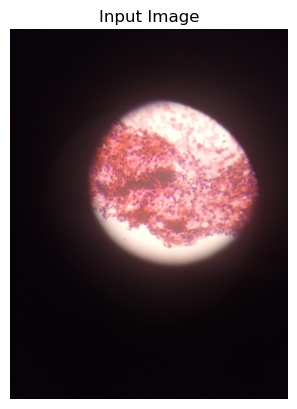

Predicted Class: Cancer, Confidence: 0.9238


In [24]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the model and evaluate
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('super_CNN_Model.pth'))  # Load the best model
model.eval()  # Set to evaluation mode

# Example inference on a single image
def predict_image(image_path, model, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.title('Input Image')
    plt.show()

    # Transform and add batch dimension
    image_transformed = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_transformed)
        probability = torch.sigmoid(output).item()  # Get the probability (confidence between 0-1)
        
        # Classify based on the probability threshold (0.5 by default)
        if probability >= 0.5:
            prediction = 'Cancer'
            confidence = probability
        else:
            prediction = 'Non-Cancer'
            confidence = 1 - probability  # Confidence for non-cancer is 1 - probability
            
    return prediction, confidence

# Use the prediction function
sample_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/TAN/001/IMG_20220623_134910.jpg'  # Replace with actual path
predicted_class, confidence = predict_image(sample_image_path, model, transform, device)
print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.4f}')